# binary igen 

In [37]:

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import sklearn
import keras
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from keras.layers import Dropout
from keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
import torch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [38]:
df = pd.read_csv('Data for python.csv', sep=';', header=1, index_col=0, decimal=',')
df = df.fillna(0)
df = df.drop(columns=['Id'])
df = df.drop(columns=['ScandcleftID'])
df = df.drop(columns=['Født'])
df = df.drop(columns=['Materialedato A'])
df = df.drop(columns=['Materialedato B'])
df = df.drop(columns=['Materialedato C'])

In [39]:
def pin_update(row):
    if row["Total Row Score C"] <= 5:
        return 1
    else:
        return 0

In [40]:
def pin_update1(row):
     if 5 < row["Total Row Score C"]:
          return 1
     else:
          return 0 

In [41]:
Output = df.apply(pin_update, axis=1)
Output1 = df.apply(pin_update1, axis=1)
df['Output'] = Output
df['Output1'] = Output1


In [42]:
df1 = df[["Anteroposterior 1",
          'Anteroposterior 2',
          'Vertical 1',
          'Vertical 2',
          'Transverse',
          'Spacing',
          'Pan 1',
          'Total Row Score A',
          'Anteroposterior 1.1',
          'Anteroposterior 2.1',
          'Vertical 1.1',
          'Vertical 2.1',
          'Transverse.1',
          'Spacing.1',
          'Pan 1.1',
          'Total Row Score B',
          'Output',
          'Output1']]
df1.iloc[1:, :]
df1.shape

(123, 18)

In [43]:
scaler = MinMaxScaler()
scaler.fit(df1)
t_df = scaler.transform(df1)

target_column = ["Output",'Output1']
numerical_column = df1.columns.drop(target_column)
output_rows = df1[target_column]
df1.drop(target_column,axis=1,inplace=True)


/var/folders/d5/qsvd0xbs3610vyxc_s5y8cv80000gn/T/ipykernel_62712/2401688291.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(target_column,axis=1,inplace=True)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(t_df, output_rows, test_size=0.25,shuffle=True)


In [45]:
no_classes = 3
no_epochs = 15
optimizer = Adam()
verbosity = 0
num_folds = 5
batch_size = 5
acc_per_fold = []
loss_per_fold = []
fold_no = 1 

In [46]:
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

kfold = KFold(n_splits=num_folds, shuffle=True)

In [50]:
for train, test in kfold.split(inputs, targets):
    model = Sequential()
    model.add(Dense(8, input_dim=18, activation='relu'))
    #model.add(Dense(16, activation='relu'))
    model.add(Dense(4,activation='relu'))
    model.add(Dense(2, activation='softmax'))
 # Compile model
    model.compile(loss='categorical_crossentropy' , optimizer='adam', metrics=['accuracy'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity)

  # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] *100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1
    
fold_no = 1 

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.2372858226299286; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.14752481877803802; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.2735384404659271; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.5801551342010498; accuracy of 75.0%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.1355569213628769; accuracy of 100.0%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.0918394252

In [51]:
predicted = model.predict(X_test)

predicted.shape

y_test.Output
tensor = torch.tensor(y_test.values)
tensor.shape

1/1 [==============================] - 0s 101ms/step


torch.Size([31, 2])

tf.Tensor(
[[0.03789418 0.9621058 ]
 [0.00557162 0.9944284 ]
 [0.98910636 0.01089368]
 [0.9611788  0.03882123]
 [0.9403546  0.05964541]
 [0.04713368 0.9528663 ]
 [0.0123075  0.98769253]
 [0.00550883 0.9944912 ]
 [0.04739634 0.9526037 ]
 [0.9576828  0.04231725]
 [0.9693448  0.03065517]
 [0.01692833 0.98307174]
 [0.8245064  0.17549361]
 [0.00363532 0.99636465]
 [0.89454526 0.10545473]
 [0.00674656 0.9932534 ]
 [0.93609315 0.06390681]
 [0.00281535 0.9971846 ]
 [0.9337602  0.06623971]
 [0.00231247 0.9976876 ]
 [0.00155957 0.99844044]
 [0.0886244  0.9113756 ]
 [0.00907888 0.99092114]
 [0.01020365 0.98979634]
 [0.97604215 0.02395787]
 [0.00102566 0.9989743 ]
 [0.00595663 0.9940434 ]
 [0.9820839  0.01791615]
 [0.96897405 0.03102596]
 [0.9718811  0.02811892]
 [0.02734105 0.972659  ]], shape=(31, 2), dtype=float32)


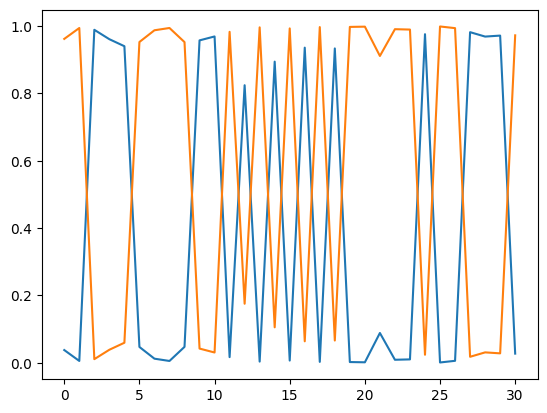

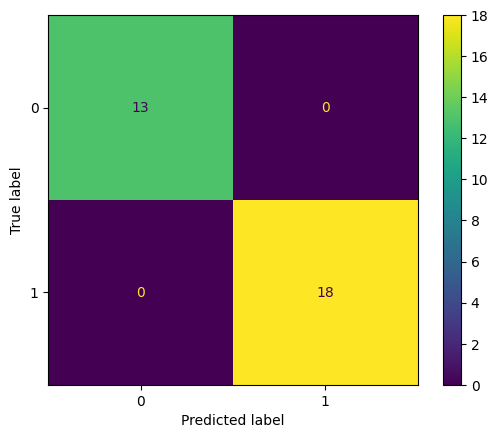

In [52]:
predicted = tf.squeeze(predicted)
plt.plot(predicted)
print(predicted)
predicted = np.array([np.argmax(row) for row in predicted])
actual = np.array([np.argmax(row) for row in tensor])
conf_mat = confusion_matrix(actual, predicted)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()